
# Semana 5 — Dashboard + Relatório + Mini-ML 🤖💰

Este notebook lê **`gastos_estudo_clean.csv`** e produz:
- **Dashboard** com 4 gráficos (linha diária, barras por categoria, barras por forma de pagamento, boxplot).
- **Relatório em Markdown** com insights automáticos (para colar no Notion).
- **Relatório em PDF** com os gráficos.
- **Mini-ML**: clustering simples de transações (K-Means).


In [32]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.backends.backend_pdf import PdfPages

# caminho do CSV
DATA_PATH = "gastos_estudo_clean.csv"

# fallback para o arquivo salvo na sessão (se existir)
if not os.path.exists(DATA_PATH):
    alt = "data/semana5_pratica_revisao/gastos_estudo_clean.csv"
    if os.path.exists(alt):
        DATA_PATH = alt

print("Usando arquivo:", DATA_PATH)

# Pasta para salvar imagens/relatórios
OUT_DIR = "relatorio/"
os.makedirs(OUT_DIR, exist_ok=True)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X","."))


Usando arquivo: gastos_estudo_clean.csv


## 1) Carregar e normalizar dados

In [33]:

df = pd.read_csv(DATA_PATH, encoding="utf-8")

def norm(s):
    return (s.strip().lower()
            .replace("(", "").replace(")", "")
            .replace(" ", "_")
            .replace("ç","c").replace("ã","a").replace("á","a")
            .replace("é","e").replace("í","i").replace("ó","o")
            .replace("ú","u").replace("â","a").replace("ê","e")
            .replace("ô","o").replace("à","a").replace("ü","u"))
orig_cols = list(df.columns)
df.columns = [norm(c) for c in df.columns]

# Detect columns
date_col = next((c for c in df.columns if c in ["data","date","dia","timestamp","data_compra","data_lancamento"]), None)
value_col = next((c for c in df.columns if c in ["valor","valor_r$","valor_rs","valor_reais","amount","preco","price","gasto","valor_(r$)","valor_(rs)","valor_(reais)"]), None)
cat_col   = next((c for c in df.columns if c in ["categoria","classificacao","classe","category"]), None)
pay_col   = next((c for c in df.columns if c in ["forma_pagamento","forma_de_pagamento","metodo_pagamento","payment_method","pagamento"]), None)
desc_col  = next((c for c in df.columns if c in ["descricao","descricao_compra","memo","observacao","description"]), None)

if date_col is None or value_col is None:
    raise ValueError("Não encontrei colunas de Data e/ou Valor no CSV.")

# Valor: converter vírgula decimal e remover separador de milhar
if df[value_col].dtype == object:
    df[value_col] = (df[value_col].astype(str)
                     .str.replace("\u00a0"," ", regex=False)
                     .str.replace(".", "", regex=False)
                     .str.replace(",", ".", regex=False))
df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

# Data: parsing robusto (prioriza ISO YYYY-MM-DD)
s = df[date_col].astype(str).str.strip()
def parse_dates_series(s: pd.Series) -> pd.Series:
    iso_mask = s.str.match(r"^\d{4}-\d{2}-\d{2}$", na=False)
    if iso_mask.mean() > 0.8:
        out = pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")
        if out.notna().mean() > 0.8:
            return out
    if s.str.contains("/", regex=False).mean() > 0.5:
        try_ddmm = pd.to_datetime(s, format="%d/%m/%Y", errors="coerce")
        try_mmdd = pd.to_datetime(s, format="%m/%d/%Y", errors="coerce")
        if try_ddmm.notna().sum() >= try_mmdd.notna().sum():
            return try_ddmm
        else:
            return try_mmdd
    return pd.to_datetime(s, errors="coerce", dayfirst=True)
df[date_col] = parse_dates_series(s)

# Limpar linhas inválidas
df = df.dropna(subset=[date_col, value_col]).copy()

# Derivadas
df["ano"] = df[date_col].dt.year
df["mes"] = df[date_col].dt.month
df["dia"] = df[date_col].dt.day
df["ym"] = df[date_col].dt.to_period("M").astype(str)
df["dow"] = df[date_col].dt.dayofweek  # 0=segunda

print("Colunas detectadas:", {"data_col": date_col, "value_col": value_col, "cat_col": cat_col, "pay_col": pay_col})
df.head(3)

Colunas detectadas: {'data_col': 'data', 'value_col': 'valor_r$', 'cat_col': 'categoria', 'pay_col': 'forma_pagamento'}


,data,categoria,descricao,valor_r$,forma_pagamento,tipo,ano,mes,dia,ym,dow
0,2025-08-07,Presente,Mercado Livre,"145,90",Cartão Crédito,Variável,2025,8,7,2025-08,3
1,2025-08-08,Assinatura,Spotify,"34,90",Cartão Crédito,Fixo,2025,8,8,2025-08,4
2,2025-08-08,Suplemento,Mercado Livre,"99,90",Cartão Crédito,Variável,2025,8,8,2025-08,4


## 2) Dashboard de gráficos

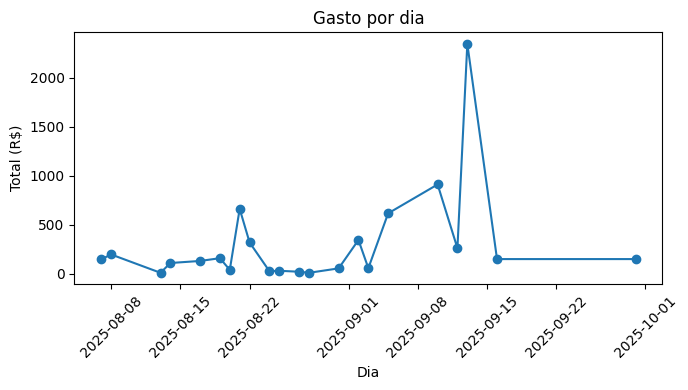

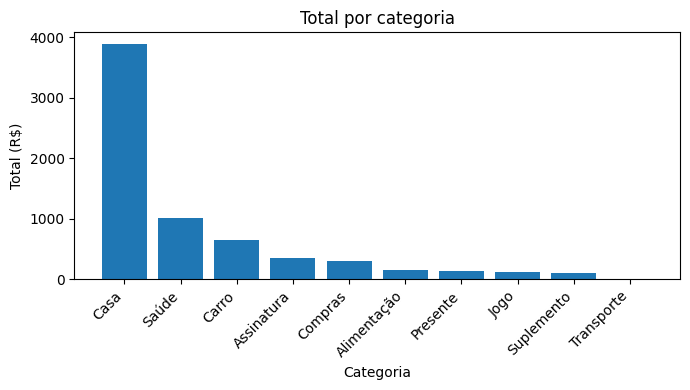

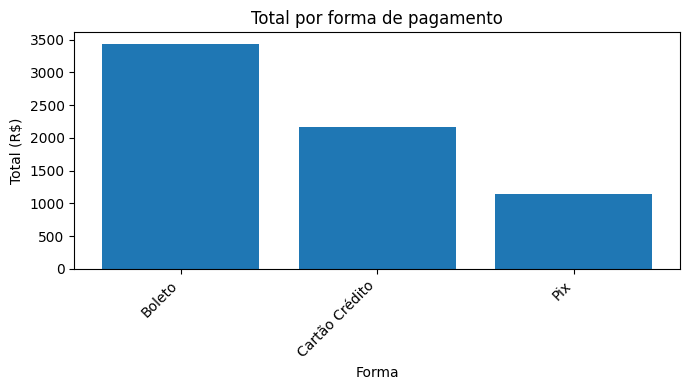

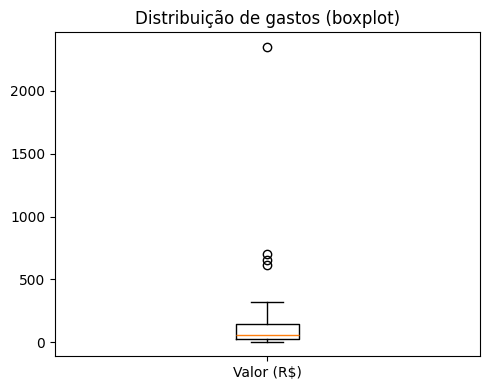

('relatório/daily.png',
 'relatório/by_category.png',
 'relatório/by_payment.png',
 'relatório/boxplot.png')

In [34]:

# 2.1 Linha diária
daily = df.groupby(df[date_col].dt.date)[value_col].sum().reset_index()
plt.figure(figsize=(7,4))
plt.plot(daily[date_col], daily[value_col], marker='o')
plt.xticks(rotation=45)
plt.title("Gasto por dia"); plt.xlabel("Dia"); plt.ylabel("Total (R$)")
plt.tight_layout()
daily_png = os.path.join(OUT_DIR, "daily.png")
plt.savefig(daily_png, dpi=150, bbox_inches="tight")
plt.show()

# 2.2 Barras por categoria
by_cat = None
if cat_col is not None and cat_col in df.columns:
    by_cat = df.groupby(cat_col)[value_col].sum().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(7,4))
    plt.bar(by_cat[cat_col].astype(str), by_cat[value_col])
    plt.xticks(rotation=45, ha="right")
    plt.title("Total por categoria"); plt.xlabel("Categoria"); plt.ylabel("Total (R$)")
    plt.tight_layout()
    cat_png = os.path.join(OUT_DIR, "by_category.png")
    plt.savefig(cat_png, dpi=150, bbox_inches="tight")
    plt.show()
else:
    cat_png = None

# 2.3 Barras por forma de pagamento
by_pay = None
if pay_col is not None and pay_col in df.columns:
    by_pay = df.groupby(pay_col)[value_col].sum().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(7,4))
    plt.bar(by_pay[pay_col].astype(str), by_pay[value_col])
    plt.xticks(rotation=45, ha="right")
    plt.title("Total por forma de pagamento"); plt.xlabel("Forma"); plt.ylabel("Total (R$)")
    plt.tight_layout()
    pay_png = os.path.join(OUT_DIR, "by_payment.png")
    plt.savefig(pay_png, dpi=150, bbox_inches="tight")
    plt.show()
else:
    pay_png = None

# 2.4 Boxplot de valores (detectar outliers)
plt.figure(figsize=(5,4))
plt.boxplot(df[value_col].dropna().values, vert=True, tick_labels=["Valor (R$)"])
plt.title("Distribuição de gastos (boxplot)")
plt.tight_layout()
box_png = os.path.join(OUT_DIR, "boxplot.png")
plt.savefig(box_png, dpi=150, bbox_inches="tight")
plt.show()

daily_png, cat_png, pay_png, box_png


## 3) Insights automáticos + Export Markdown

In [35]:

total = df[value_col].sum()
qtd = df[value_col].count()
media = df[value_col].mean()
mediana = df[value_col].median()

insights = []
insights.append(f"Total gasto: **R$ {total:,.2f}** em {qtd} transações.")
insights.append(f"Média/Mediana: **R$ {media:,.2f}** / **R$ {mediana:,.2f}**.")

# Top categoria
if 'by_cat' in locals() and by_cat is not None and not by_cat.empty:
    top_cat = by_cat.iloc[0,0]
    top_val = by_cat.iloc[0,1]
    share = top_val / total if total > 0 else 0
    insights.append(f"Categoria dominante: **{top_cat}** (**R$ {top_val:,.2f}**, {share:.1%} do total).")

# Dia de maior gasto
if not daily.empty:
    idxmax = daily.iloc[:,1].idxmax()
    dia_max = daily.iloc[idxmax, 0]
    val_max = daily.iloc[idxmax, 1]
    insights.append(f"Dia com maior gasto: **{dia_max}** (R$ {val_max:,.2f}).")

# Outliers por IQR
q1, q3 = df[value_col].quantile(0.25), df[value_col].quantile(0.75)
iqr = q3 - q1
limite = q3 + 1.5 * iqr
outliers = df[df[value_col] > limite]
if not outliers.empty:
    insights.append(f"Outliers detectados: **{len(outliers)}** (>{limite:,.2f}).")
else:
    insights.append("Sem outliers relevantes pelo critério IQR.")

# Montar Markdown (links relativos às imagens geradas)
md_lines = [
    "# Relatório de Gastos — Dashboard",
    "",
    "## Resumo",
    *[f"- {line}" for line in insights],
    "",
    "## Gráficos",
]
if os.path.exists(daily_png): md_lines.append(f"![Gasto diário]({os.path.basename(daily_png)})")
if 'cat_png' in locals() and cat_png and os.path.exists(cat_png): md_lines.append(f"![Por categoria]({os.path.basename(cat_png)})")
if 'pay_png' in locals() and pay_png and os.path.exists(pay_png): md_lines.append(f"![Por forma de pagamento]({os.path.basename(pay_png)})")
if os.path.exists(box_png): md_lines.append(f"![Boxplot]({os.path.basename(box_png)})")

md_text = "\n".join(md_lines)
md_path = os.path.join(OUT_DIR, "relatorio_gastos.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write(md_text)

print("\n".join(insights))
md_path


Total gasto: **R$ 6,761.10** em 37 transações.
Média/Mediana: **R$ 182.73** / **R$ 59.90**.
Categoria dominante: **Casa** (**R$ 3,890.11**, 57.5% do total).
Dia com maior gasto: **2025-09-13** (R$ 2,349.53).
Outliers detectados: **4** (>324.40).


'relatório/relatorio_gastos.md'

## 4) Exportar PDF (gráficos)

In [36]:

pdf_path = os.path.join(OUT_DIR, "relatorio_gastos.pdf")
with PdfPages(pdf_path) as pdf:
    # 1) Daily
    plt.figure(figsize=(7,4))
    plt.plot(daily.iloc[:,0], daily.iloc[:,1], marker='o')
    plt.xticks(rotation=45); plt.xlabel("Dia"); plt.ylabel("Total (R$)")
    plt.title("Gasto por dia"); plt.tight_layout()
    pdf.savefig(); plt.close()

    # 2) Categoria
    if 'by_cat' in locals() and by_cat is not None and not by_cat.empty:
        plt.figure(figsize=(7,4))
        plt.bar(by_cat.iloc[:,0].astype(str), by_cat.iloc[:,1])
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Categoria"); plt.ylabel("Total (R$)")
        plt.title("Total por categoria"); plt.tight_layout()
        pdf.savefig(); plt.close()

    # 3) Forma de pagamento
    if 'by_pay' in locals() and by_pay is not None and not by_pay.empty:
        plt.figure(figsize=(7,4))
        plt.bar(by_pay.iloc[:,0].astype(str), by_pay.iloc[:,1])
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Forma"); plt.ylabel("Total (R$)")
        plt.title("Total por forma de pagamento"); plt.tight_layout()
        pdf.savefig(); plt.close()

    # 4) Boxplot
    plt.figure(figsize=(5,4))
    plt.boxplot(df[value_col].dropna().values, vert=True, tick_labels=["Valor (R$)"])
    plt.title("Distribuição de gastos (boxplot)"); plt.tight_layout()
    pdf.savefig(); plt.close()

pdf_path


'relatório/relatorio_gastos.pdf'

## 5) Mini-ML: Clustering (K-Means) dos gastos

   cluster  count   mean  median   min      max
0        0      3  39,93   49,99  9,90    59,90
1        1     11  33,39   26,90  5,90   118,74
2        2      6  50,86   40,00 10,00   122,00
3        3     13 446,84  150,00 99,90 2.349,53
4        4      4  40,00   37,50 14,00    71,00
Silhouette (todos os pontos): 0.52


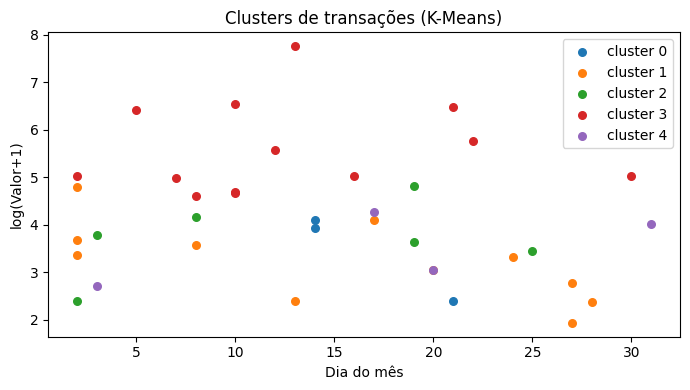

,cluster,count,mean,median,min,max
0,0,3,"39,93","49,99","9,90","59,90"
1,1,11,"33,39","26,90","5,90","118,74"
2,2,6,"50,86","40,00","10,00","122,00"
3,3,13,"446,84","150,00","99,90","2.349,53"
4,4,4,"40,00","37,50","14,00","71,00"


In [37]:

# Features para clustering por transação:
# - valor (log transform para reduzir assimetria)
# - dia da semana (0..6)
# - top 5 categorias (one-hot), se existir
X_feats = pd.DataFrame(index=df.index)
X_feats["valor_log"] = np.log1p(df[value_col].clip(lower=0))
X_feats["dow"] = df["dow"]

if cat_col is not None and cat_col in df.columns:
    top_cats = df[cat_col].value_counts().head(5).index.tolist()
    for c in top_cats:
        X_feats[f"cat_{c}"] = (df[cat_col] == c).astype(int)

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feats.fillna(0))

# K-Means
k = 5
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = km.fit_predict(X_scaled)

df_clusters = df.copy()
df_clusters["cluster"] = labels

# Resumo
cluster_summary = df_clusters.groupby("cluster")[value_col].agg(["count","mean","median","min","max"]).reset_index()
print(cluster_summary)

# Silhouette (se k>=2)
try:
    sil = silhouette_score(X_scaled, labels)
    print("Silhouette (todos os pontos):", round(sil, 3))
except Exception as e:
    print("Silhouette indisponível:", e)

# Plot simples: dia do mês vs log(valor), colorido por cluster
# Para não definir cores explicitamente, plota cluster por cluster usando o ciclo padrão.
plt.figure(figsize=(7,4))
for cl in sorted(df_clusters["cluster"].unique()):
    mask = df_clusters["cluster"] == cl
    plt.scatter(df_clusters.loc[mask, date_col].dt.day, np.log1p(df_clusters.loc[mask, value_col]), s=30, label=f"cluster {cl}")
plt.xlabel("Dia do mês"); plt.ylabel("log(Valor+1)"); plt.title("Clusters de transações (K-Means)")
plt.legend()
plt.tight_layout(); plt.show()

cluster_summary.head()


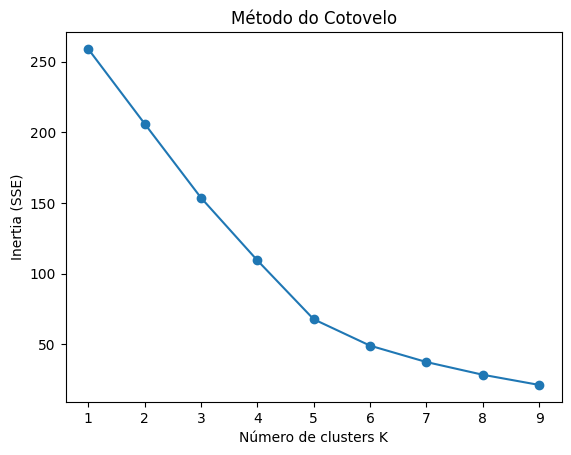

In [38]:
inertias = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, '-o')
plt.xlabel('Número de clusters K')
plt.ylabel('Inertia (SSE)')
plt.title('Método do Cotovelo')
plt.show()